### In this notebook, we use [RAPIDS cudf](https://github.com/rapidsai/cudf) to create a bunch of useful features and train XGB models. The entire pipeline is lightning-fast thanks to GPU end-to-end acceleration. Train time is 28 mins and test time is 5 mins. The CV is score is `0.795` and LB score is `0.795`

### What you might find useful from this notebook:
### The original dataset is train + test = 49 GB, so I have converted all the float64 to float32 and other float columns to int8 which has reduced the overall data by 90%!!!!!
### attached is the notebook link for csv to parquet,picle conversion using PYSPARK https://spark.apache.org/docs/latest/api/python/, with some feature size reduction. https://www.kaggle.com/code/sohailshaik272/csv-to-parquet-pickle-amex
### - Super fast pipeline. LB 0.795 in 28 mins!
### The test data set has 11 million rows and 190 features so as the train dataset.
### This notebook employs a way to read data in small chunks to address memory error.
### I have used xgboost in this notebook, it has taken care of missing values since its gradient boosting algorithm.
### The dataset is imbalanced with 25% postive class and 75% negative class
### The metric used in this competition is gini, which uses lorrentz curve, only 5% of data is calculated for metric giving weightage to negative class by 20 times.
### - "After-pay" features. It makes intuitive semse that subtracting the payments from balance/spend etc provides new information about the users' behavior.
### - Scalable streaming prediction. Each time only a chunk of test data is read, processed and predicted. If more features are added, you could simply make `chunks` bigger and never worry about GPU out of memory 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/american-express-default-prediction-snappy-parquet/train_data.snappy.parquet
/kaggle/input/american-express-default-prediction-snappy-parquet/test_data.snappy.parquet
/kaggle/input/american-express-default-prediction-snappy-parquet/train_labels.snappy.parquet


In [2]:
pip install GPUtil

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=fbeac3ada5d2f60b2cbf3595df9146a19dd72437a1d96fec7d1aad45f6445e53
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Note: you may need to restart the kernel to use updated packages.


# 1. Import packages

In [3]:
import warnings
import gc
import time
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#RAPIDS packages
import cudf
import cupy
import xgboost as xgb
from tqdm import tqdm
cudf.__version__

#visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

Some things about Data

* D_* (Deliquency variables) - Credit card delinquency refers to falling behind on required monthly payments to credit card companies.
* S_* (Spend Variables) - Expenditure done on credit card.
* P_* (Payment variables) - How timely the customer is paying the credit card bill
* B_* (Balance variables) - How much balance is remaining to pay, i.e if he is doing part or full payments 
* R_* (Risk variables) - The customer's repaying capacity or his financial health, credit score etc.


# 2. EDA functions

In [4]:
#Class to inspect missing values

class ExploratoryDataAnalysis:
    @classmethod
    def summary_table(cls,df):
        '''Objective : This function provides missing, pct_missing values and unique values in 
    column'''
        df = df.copy()
        print(f'The shape of dataframe is:{df.shape}')
        summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
        summary = summary.reset_index()
        summary['Name'] = summary['index']
        summary = summary[['Name','dtypes']]
        summary['Missing'] = df.isnull().sum().values
        summary['pct_Missing_values'] = df.isnull().sum().values/ len(df)
        summary['Uniques'] = df.nunique().values
        del df
        return summary
    @classmethod
    def plot_missing_values(cls,summary):
        '''Plot missing values'''
        summary = summary.sort_values(by='pct_Missing_values', ascending = False)
        plt.figure(figsize = (20,20))
        j = 0
        k = 0
        for i in range(10,len(summary),10):
            k += 1
            plt.subplot(6,3,k)
            plt.bar(summary['Name'][j:i],summary['pct_Missing_values'][j:i])
            j = i
        del summary
    @classmethod
    def train_labels(cls,df_train_labels):
        target=df_train_labels.target.value_counts(normalize=True)
        target.rename(index={1:'Default',0:'Paid'},inplace=True)
        pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
        fig=go.Figure()
        fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     showlegend=True,sort=False, 
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
        fig.update_layout(template=temp, title='Target Distribution', 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
        fig.show()
        del target
    @classmethod
    def counting_statements_per_customer(cls,train,test):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        train_sc = train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
        ax1.pie(train_sc, labels=train_sc.index)
        ax1.set_title(train_sc.name)
        test_sc = test.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Test statements per customer')
        ax2.pie(test_sc, labels=test_sc.index)
        ax2.set_title(test_sc.name)
        plt.show()   
gc.collect()

30

In [5]:
df_train = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet")

The shape of dataframe is:(5531451, 190)


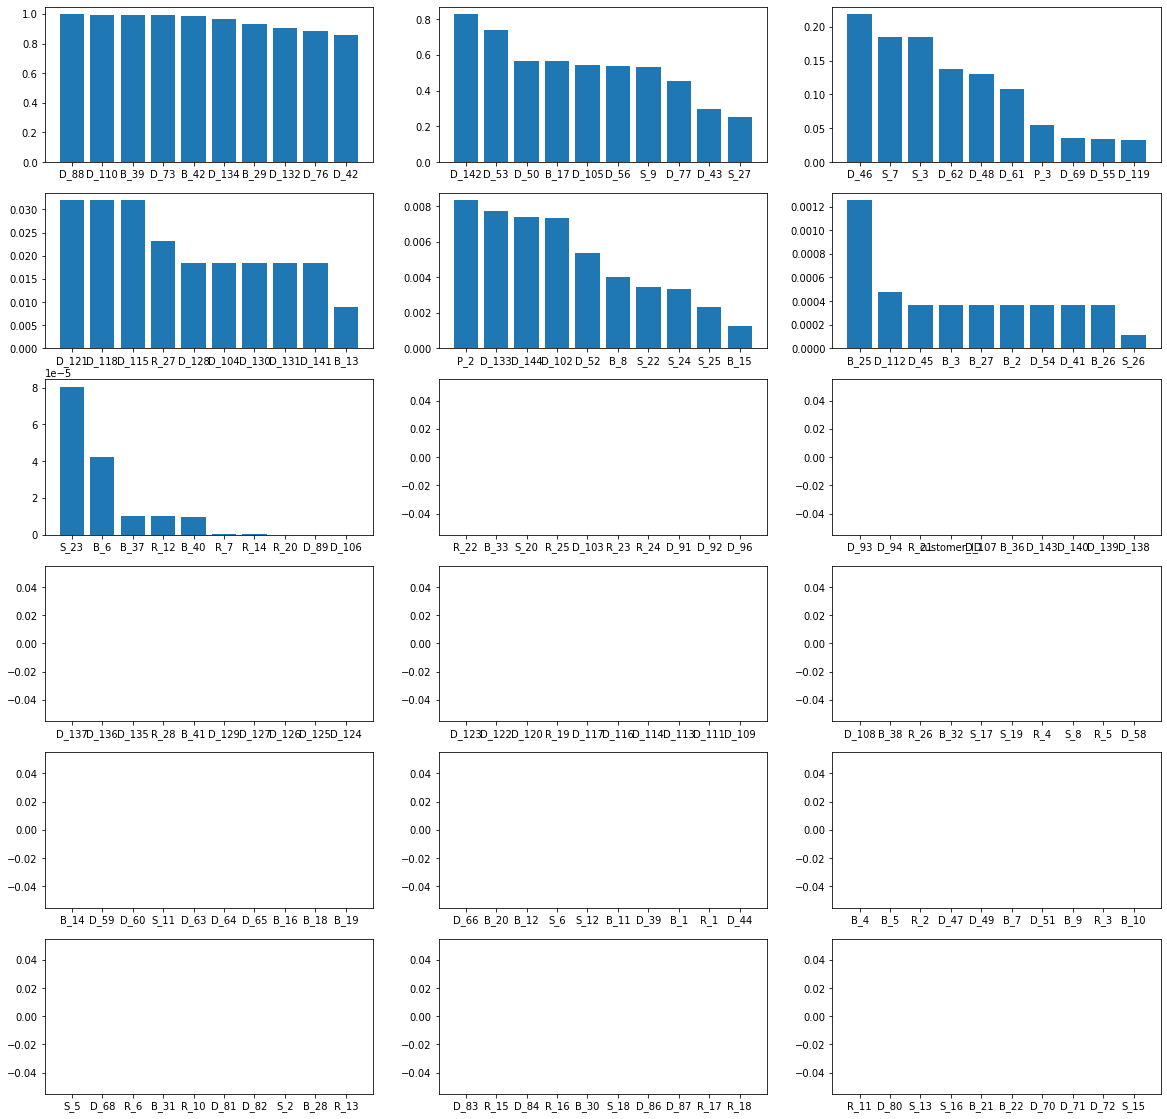

In [6]:
summary_df = ExploratoryDataAnalysis.summary_table(df_train)
ExploratoryDataAnalysis.plot_missing_values(summary_df)

We see many columns with missing values, hence we need to decide on best imputation strategy.

In [7]:
df_train_labels = pd.read_parquet("../input/american-express-default-prediction-snappy-parquet/train_labels.snappy.parquet")
ExploratoryDataAnalysis.train_labels(df_train_labels)

The target column is imbalanced ie approximately 75% observations are not default and 25% are defaulted, hence we need to be careful and select a balanced sample so that the model is not biased towards the higher number of observations.

More than 80% customers have 13 statements and 20% have less than 13 statements between (1 to 12), this means

Insight: Our model will have to deal with a variable-sized input per customer (unless we simplify our life and look only at the most recent statement as @inversion suggests https://www.kaggle.com/competitions/amex-default-prediction/discussion/327094 or at the average over all statements).

In [8]:
del summary_df,df_train_labels,df_train
gc.collect()

61908

# 3. Feature Engineering

**After pay features** - Lets subtract the payment variables from Spend variables so we might know a new behaviour of the user.

In [9]:
def preprocess(df):
    df['row_id'] = cupy.arange(df.shape[0])
    not_used = ['row_id', 'customer_ID', 'target', 'cid', 'S_2']
    category_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
                'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    
    #[df[col].round(2) for col in df.columns if col not in category_columns + not_used]
    
    #compute after pay features
    #for scol in [f'S_{i}' for i in [3,5,6,7,8,9,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27]]:
        #for pcol in ['P_2','P_3','P_4']:
            #df[f'{scol}-{pcol}'] = df[scol] - df[pcol]
            
    for col in df.columns:
        if col not in not_used+category_columns:
            df[col] = df[col].round(2)

    # compute "after pay" features
    for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
        for pcol in ['P_2','P_3']:
            if bcol in df.columns:
                df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]
    
    df['S_2'] = cudf.to_datetime(df['S_2'])
    df['cid'], _ = df.customer_ID.factorize()
    
    num_cols = [col for col in df.columns if col not in category_columns+not_used]
    
    dgs = add_stats_step(df,num_cols)
    
    #sort and drop using row_id
    df = df.sort_values('row_id')
    df = df.drop(['row_id'], axis = 1)
    return df, dgs

def add_stats_step(df, cols):
    n = 10
    dgs = []
    for i in range(0,len(cols),n):
        s = i
        e = min(s+n, len(cols))
        dg = add_stats_one_shot(df, cols[s:e])
        dgs.append(dg)
    return dgs

def add_stats_one_shot(df, cols):
    stats = ['mean','std']
    dg = df.groupby('customer_ID').agg({col:stats for col in cols})
    out_cols = []
    for col in cols:
        out_cols.extend([f'{col}_{s}' for s in stats])
    dg.columns = out_cols
    dg = dg.reset_index()
    return dg

def load_test_iter(path, chunks):
    
    test_rows = 11363762 
    chunk_rows = test_rows // chunks
    
    test = cudf.read_parquet(f'{path}/test.parquet',
                             columns=['customer_ID','S_2'],
                             num_rows=test_rows)
    test = get_segment(test)
    start = 0
    while start < test.shape[0]:
        if start+chunk_rows < test.shape[0]:
            end = test['cus_count'].values[start+chunk_rows]
        else:
            end = test['cus_count'].values[-1]
        end = int(end)
        df = cudf.read_parquet(f'{path}/test.parquet',
                               num_rows = end-start, skiprows=start)
        start = end
        yield process_data(df)
    

def load_train(path):
    train = cudf.read_parquet(f'{path}/train.parquet')
    
    train = process_data(train)
    train_labels = cudf.read_parquet('../input/american-express-default-prediction-snappy-parquet/train_labels.snappy.parquet')
    train = train.merge(train_labels, on='customer_ID', how='left')
    return train

def process_data(df):
    df,dgs = preprocess(df)
    df = df.drop_duplicates('customer_ID',keep='last')
    for dg in dgs:
        df = df.merge(dg, on='customer_ID', how='left')
    diff_cols = [col for col in df.columns if col.endswith('_diff')]
    df = df.drop(diff_cols,axis=1)
    return df

def get_segment(test):
    dg = test.groupby('customer_ID').agg({'S_2':'count'})
    dg.columns = ['cus_count']
    dg = dg.reset_index()
    dg['cid'],_ = dg['customer_ID'].factorize()
    dg = dg.sort_values('cid')
    dg['cus_count'] = dg['cus_count'].cumsum()
    
    test = test.merge(dg, on='customer_ID', how='left')
    test = test.sort_values(['cid','S_2'])
    assert test['cus_count'].values[-1] == test.shape[0]
    return test

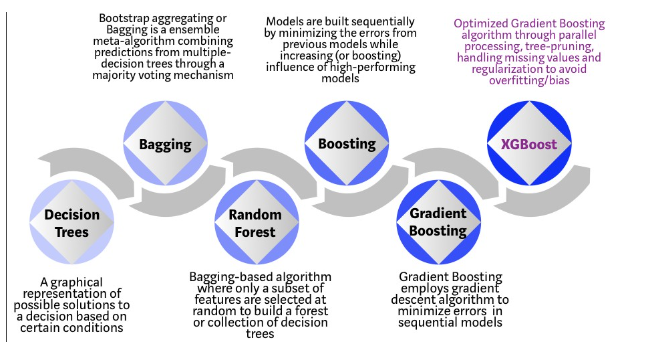

# 4. XGB Params 

In [10]:
def xgb_train(x, y, xt, yt):
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    dtrain = xgb.DMatrix(data=x, label=y)
    dvalid = xgb.DMatrix(data=xt, label=yt)
    params = {
            'objective': 'binary:logistic', 
            'tree_method': 'gpu_hist', 
            'max_depth': 7,
            'subsample':0.88,
            'colsample_bytree': 0.5,
            'gamma':1.5,
            'min_child_weight':8,
            'lambda':70,
            'scale_pos_weight': 4,
            'eta':0.03,
    }
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    bst = xgb.train(params, dtrain=dtrain,
                num_boost_round=2600,evals=watchlist,
                early_stopping_rounds=500, feval=xgb_amex, maximize=True,
                verbose_eval=100)
    print('best ntree_limit:', bst.best_ntree_limit)
    print('best score:', bst.best_score)
    return bst.predict(dvalid, iteration_range=(0,bst.best_ntree_limit)), bst

# 5. Metrics

**amex_metric_np** - works 12x faster than orignal metric function so i used this metric during training.

**amex_metric** - This is orignal pandas metric that is evaluated by AMEX

In [11]:
def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())

# Created by https://www.kaggle.com/yunchonggan
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

# we still need the official metric 
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

# 6. Free up GPU memory 

In [12]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")

In [13]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache


# 7. Load train data and add additional features 

In [14]:
%%time

path = '../input/amex-data-integer-dtypes-parquet-format'
train = load_train(path)

CPU times: user 11.3 s, sys: 4.97 s, total: 16.3 s
Wall time: 18.6 s


# 8. K- fold cross validations training

In [15]:
%%time

not_used = ['row_id', 'customer_ID', 'target', 'cid', 'S_2']
not_used = [i for i in not_used if i in train.columns]
msgs = {}
folds = 4
score = 0

for i in range(folds):
    mask = train['cid']%folds == i
    tr,va = train[~mask], train[mask]
    
    x, y = tr.drop(not_used, axis=1), tr['target']
    xt, yt = va.drop(not_used, axis=1), va['target']
    yp, bst = xgb_train(x, y, xt, yt)
    bst.save_model(f'xgb_{i}.json')
    amex_score = amex_metric(pd.DataFrame({'target':yt.values.get()}), 
                                    pd.DataFrame({'prediction':yp}))
    msg = f"Fold {i} amex {amex_score:.4f}"
    print(msg)
    score += amex_score
score /= folds
print(f"Average amex score: {score:.4f}")

# of features: 584
[0]	train-logloss:0.67573	train-amex:0.67201	eval-logloss:0.67581	eval-amex:0.66804
[100]	train-logloss:0.30302	train-amex:0.77547	eval-logloss:0.31083	eval-amex:0.76403
[200]	train-logloss:0.27844	train-amex:0.79639	eval-logloss:0.29149	eval-amex:0.77935
[300]	train-logloss:0.26736	train-amex:0.80827	eval-logloss:0.28472	eval-amex:0.78545
[400]	train-logloss:0.25959	train-amex:0.81690	eval-logloss:0.28073	eval-amex:0.78786
[500]	train-logloss:0.25291	train-amex:0.82453	eval-logloss:0.27775	eval-amex:0.78997
[600]	train-logloss:0.24721	train-amex:0.83056	eval-logloss:0.27561	eval-amex:0.79085
[700]	train-logloss:0.24228	train-amex:0.83630	eval-logloss:0.27383	eval-amex:0.79091
[800]	train-logloss:0.23711	train-amex:0.84156	eval-logloss:0.27202	eval-amex:0.79159
[900]	train-logloss:0.23281	train-amex:0.84632	eval-logloss:0.27066	eval-amex:0.79167
[1000]	train-logloss:0.22853	train-amex:0.85059	eval-logloss:0.26929	eval-amex:0.79162
[1100]	train-logloss:0.22415	train-a

# 9. Feature Importance for the model

We can actually try dropping these columns from the training dataset and perform the analysis again and see if it changes the accuracy of the model.

In [16]:
dict(sorted(bst.get_score(importance_type='gain').items(), key=lambda item: item[1], reverse = True))

{'B_11-P_2': 2723.3603515625,
 'B_11-P_2_mean': 2362.70849609375,
 'S_16-P_2': 1619.6966552734375,
 'D_131-P_2': 637.8218383789062,
 'R_2': 451.2153015136719,
 'B_14-P_2': 352.2897644042969,
 'P_2': 288.55560302734375,
 'S_23-P_2': 253.73777770996094,
 'B_1': 252.8272247314453,
 'R_1': 225.1171417236328,
 'R_4': 180.07725524902344,
 'D_44': 149.0164337158203,
 'D_112': 115.25687408447266,
 'D_42_mean': 112.94566345214844,
 'B_11': 111.6866683959961,
 'D_41': 108.51553344726562,
 'B_2': 105.02325439453125,
 'B_37': 103.30450439453125,
 'D_39': 100.48798370361328,
 'D_51': 87.80859375,
 'B_22': 82.74152374267578,
 'S_3_mean': 77.83736419677734,
 'D_54': 77.46963500976562,
 'B_9': 77.04505157470703,
 'R_5': 76.84635162353516,
 'D_110': 76.201416015625,
 'B_33': 72.82443237304688,
 'D_66': 72.1113510131836,
 'B_7': 67.00603485107422,
 'R_25': 65.203125,
 'R_1_mean': 64.371826171875,
 'D_65': 61.29071044921875,
 'R_3_mean': 61.1622428894043,
 'D_51_mean': 57.83904266357422,
 'B_18': 56.4313

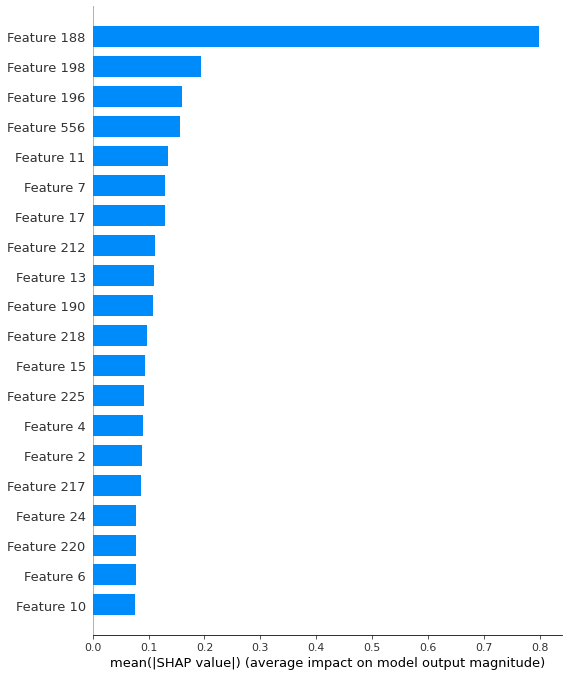

In [17]:
import shap
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(xt)
shap.summary_plot(shap_values, xt, plot_type="bar")

In [18]:
del train,explainer,shap_values,shap
gc.collect()

5105

# 10. Now testing the model on test data set

In [19]:
%%time
cids = []
yps = []
chunks = 10
for df in tqdm(load_test_iter(path,chunks),total=chunks):
    cids.append(df['customer_ID'])
    not_used = [i for i in not_used if i in df.columns]

    yp = 0
    for i in range(folds):
        bst = xgb.Booster()
        bst.load_model(f'xgb_{i}.json')
        dx = xgb.DMatrix(df.drop(not_used, axis=1))
        print('best ntree_limit:', bst.best_ntree_limit)
        yp += bst.predict(dx, iteration_range=(0,bst.best_ntree_limit))
    yps.append(yp/folds)
    
df = cudf.DataFrame()
df['customer_ID'] = cudf.concat(cids)
df['prediction'] = np.concatenate(yps)
df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 10%|█         | 1/10 [01:21<12:16, 81.86s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 20%|██        | 2/10 [01:57<07:16, 54.61s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 30%|███       | 3/10 [02:32<05:20, 45.74s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 40%|████      | 4/10 [03:07<04:09, 41.58s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 50%|█████     | 5/10 [03:42<03:16, 39.26s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 60%|██████    | 6/10 [04:17<02:30, 37.75s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 70%|███████   | 7/10 [04:53<01:51, 37.01s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 80%|████████  | 8/10 [05:28<01:12, 36.40s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


 90%|█████████ | 9/10 [06:03<00:36, 36.14s/it]

best ntree_limit: 2342
best ntree_limit: 1500
best ntree_limit: 1543
best ntree_limit: 1960


100%|██████████| 10/10 [06:39<00:00, 39.91s/it]

CPU times: user 9min 10s, sys: 21.5 s, total: 9min 31s
Wall time: 6min 39s


,customer_ID,prediction
0,0bbd927030399e0824eb278cd8b99b01bd58194babdf77...,0.940589
1,0bbe3fa490423d9c12feea0c52a5ca7f3fd039437832ef...,0.180893
2,0bbdbe1a05ca6cc76d63f295b2ea93011f17d8b69dfe01...,0.005551
3,0bbe7f0546c31ec5b668887ee2121aabd74acf3a3df315...,0.003334
4,0bbf3b8b59174032fbefb467406ccfca8f8a0901d12960...,0.813695
